In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
# from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "dotted"
plt.rcParams["errorbar.capsize"] = 2
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["savefig.pad_inches"] = 0.01
plt.rcParams["savefig.format"] = "pdf"

# from uncertainties import unumpy as unp
from uncertainties import ufloat
from uncertainties.unumpy import uarray
from uncertainties.unumpy import nominal_values as unominal
from uncertainties.unumpy import std_devs as ustdev

def ufloat_to_latex(uf, filename, var=None, dim=None, folder='tables'):
    res = ''
    if var is not None:
        res += var + '='
    res += f"{uf:L}"
    if dim is not None:
        res += ' \\ ' + dim
    with open(folder + '/' + filename, 'w') as f:
        print(res, file=f)

In [2]:
V = ufloat(1200, 3)  # см3
LdivS = ufloat(5.5, 0.5)  # см-1 
T0 = ufloat(295, 1)  # К
P0 = ufloat(745.7, 0.1)  # торр

ufloat_to_latex(V, "V.tex", r"V_1 \approx V_2", "см^3")
ufloat_to_latex(LdivS, "LdivS.tex", r"L/S", "см^{-1}")
ufloat_to_latex(T0, "T.tex", r"T", "K")
ufloat_to_latex(P0, "P.tex", r"P", "торр")

In [3]:
filenames = ['data/40.csv', 'data/80.csv', 'data/120.csv', 'data/160.csv']
pressures = [40, 80, 120, 160]
dP = 40 * 0.5 / 5.5
dataframes = [pd.read_csv(filename) for filename in filenames]

dataframes[0]

,t (s),V (mV)
0,0.000,23.1494
1,1.050,23.0786
2,2.099,23.0097
3,3.149,22.9421
4,4.163,22.8796
...,...,...
232,232.162,12.0607
233,233.162,12.0261
234,234.162,11.9938
235,235.162,11.9600


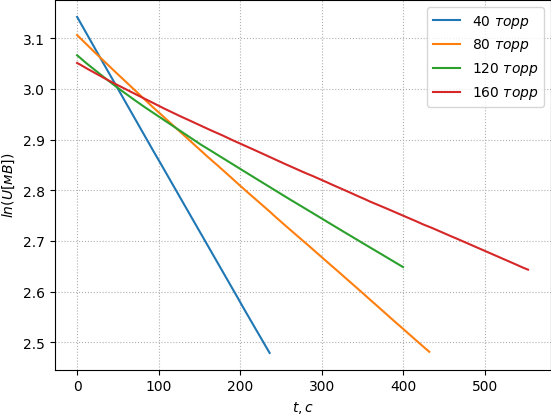

In [4]:
plt.xlabel(r"$t, с$")
plt.ylabel(r"$ln(U[мВ])$")

diffusivity = []
for df, pressure in zip(dataframes, pressures):
    x_data, y_data = df["t (s)"], np.log(df["V (mV)"])

    plt.plot(x_data, y_data, label=f"${pressure} \ торр$")

    func = lambda x, a, b: a * x + b
    popt, pcov = curve_fit(func, x_data, y_data)
    perr = np.sqrt(np.diag(pcov))

    D = -0.5 * ufloat(popt[0], perr[0]) * V * LdivS
    diffusivity.append(D)

plt.legend()
plt.savefig("images/lnU(t)")

In [14]:
diffusivity_df = pd.DataFrame()
diffusivity_df["D"] = diffusivity
diffusivity_df["P"] = uarray(pressures, dP)
header = [r"$D$, $см^2 \cdot с^{{-1}}$", r"$P$, $торр$"]
diffusivity_df.to_latex(buf=f"tables/diffusivity_table.tex", index=False, formatters=["${:L}$".format] * 2, header=header)
diffusivity_df

,D,P
0,9.3+/-0.8,40+/-4
1,4.7+/-0.4,80+/-4
2,3.38+/-0.31,120+/-4
3,2.39+/-0.22,160+/-4


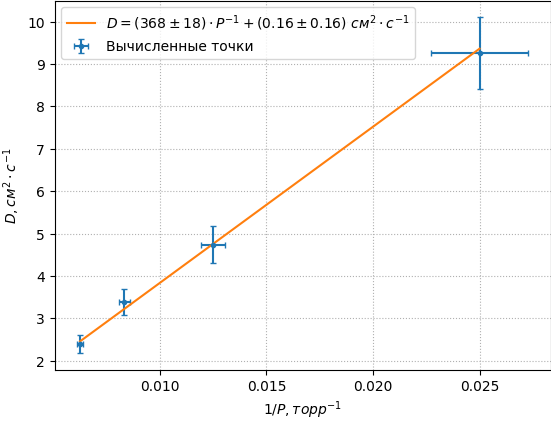

In [6]:
plt.xlabel(r"$1/P, торр^{-1}$")
plt.ylabel(r"$D, см^2 \cdot с^{-1}$")

x_data_unp = 1 / uarray(pressures, dP)
x_data, x_err = unominal(x_data_unp), ustdev(x_data_unp)
y_data, y_err = unominal(diffusivity), ustdev(diffusivity)

plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, fmt='.', label="Вычисленные точки")

func = lambda x, a, b: a * x + b
popt, pcov = curve_fit(func, x_data, y_data, sigma=y_err)
perr = np.sqrt(np.diag(pcov))
a = ufloat(popt[0], perr[0])
b = ufloat(popt[1], perr[1])
plt.plot(x_data, func(x_data, *popt), label=r"$D=" + f"({a:L}) \cdot " + r"P^{-1}+" + f"({b:L})" + r"\ см^2 \cdot с^{-1}$")

plt.legend()
plt.savefig("images/D(1divP)")

In [7]:
D0 = func(1 / P0, a, b)  # см2с-1
ufloat_to_latex(D0, "D0.tex", "D_{He-в}^{атм}", "см^2 \cdot с^{-1}")
ufloat_to_latex(ufloat(0.62, 0.01), "D_real.tex", "D_{He-в}^{табл}", "см^2 \cdot с^{-1}")
D0

0.6503064154792884+/-0.16450462335298974

In [8]:
M = ufloat(4, 0.01) / 1000  # кг/моль
R = ufloat(8.314, 0.001)  # Дж/моль/К
v = ((8 * R * T0) / (np.pi * M)) ** 0.5
lambda0 = 3e-4 * np.array(D0) / v * 1e9  # нм
ufloat_to_latex(lambda0, "lambda0.tex", r"\lambda_{He}^{атм}", "нм")
lambda0

156.12886898473224+/-39.49647575958925

In [9]:
k = ufloat(1.380, 0.001) * 1e-23  # Дж/К
n0 = (P0 * ufloat(133.3, 0.1)) / (k * T0)
sigma0 = 1 / (n0 * lambda0 / 1e9) * 1e18  # нм2
ufloat_to_latex(sigma0, "sigma0.tex", "\sigma_{He-в}^{атм}", "нм^2")
sigma0 

0.2623152842450294+/-0.066371304521135

In [10]:
r = ufloat(1.05e-1, 0.01e-1)
sigma_real = np.pi * (2 * r) ** 2
ufloat_to_latex(sigma_real, "sigma_real.tex", "\sigma_{He-в}^{теор}=\pi d_{He}^2", "нм^2")
sigma_real

0.13854423602330987+/-0.002638937829015426